# Table of Contents

- [Vanishing Gradient](#vanishing-gradient)
- [Residual Blocks](#resblock)
- [Global Average Pooling](#gap)
- [Residual Network (ResNet)](#resnet)
- [Exercises](#exercises)


# Housekeeping
- Some references for today
  - [Official pytorch tutorials](https://pytorch.org/tutorials/)
  - [Pytorch tutorials by yunjey, from beginning to advanced](https://github.com/yunjey/pytorch-tutorial)
  - [Deep Learning Book on ConvNets](https://www.deeplearningbook.org/contents/convnets.html)
  - [Modern CNN in Dive into Deep Learning](https://d2l.ai/chapter_convolutional-modern/index.html) (note, they use MXNet to
    build the networks, so the code is not usefule for us, but the
    explanations should be)
- Today's url
  - https://git.io/ml2021-08
- Email if you need help with any of this!

# Review of Convolutional Network Structure


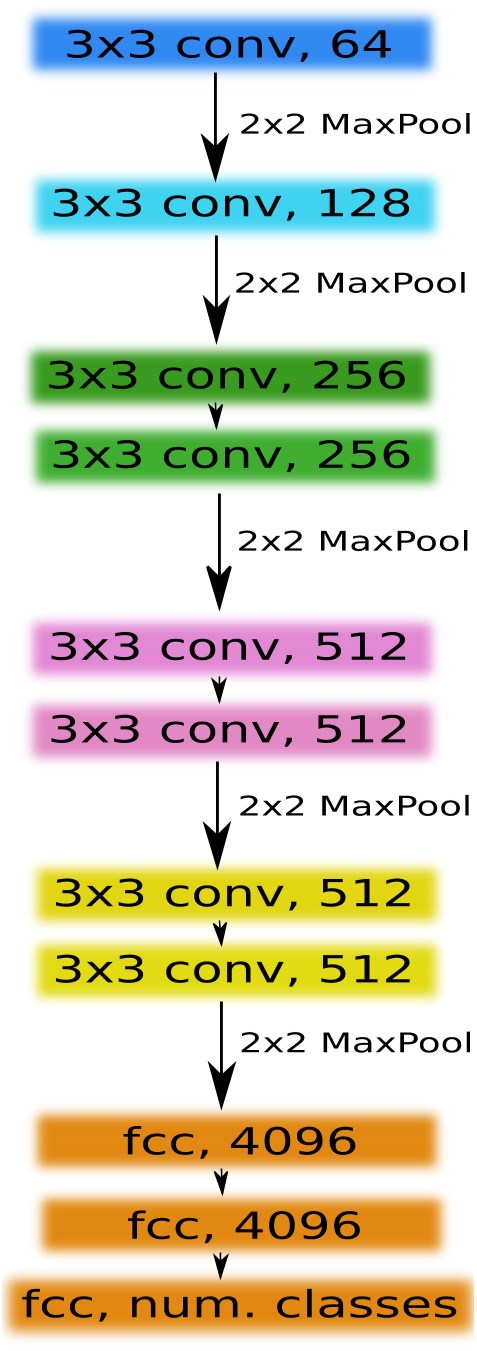

In [ ]:
from IPython.display import Image
Image('vggnet.jpg',width=160)

- Previously, we made our network from convolutional layers put together in series
- These also have some issues when trying to go deep (many, many layers)
- For the final layer, we also always `view`'d the data a single
  vector, the passed through some fully-connected layers
- This means an explosion of parameters to be optimized
- We'll look today at some more modern, advanced networks which aim to
  solve these issues

# Going Deep: The Vanishing Gradient Problem <a id="vanishing" />

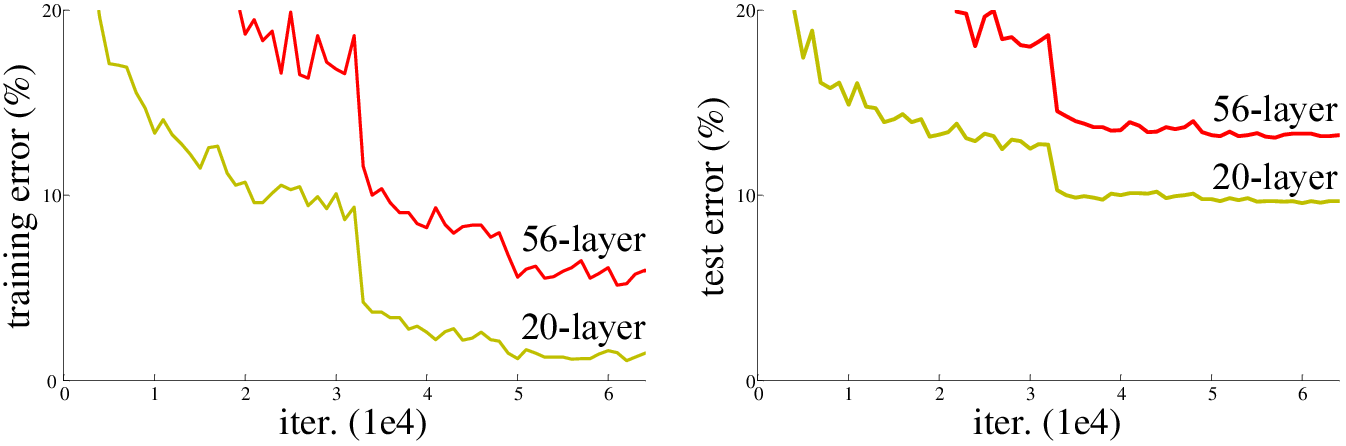

In [ ]:
Image("teaser.png",width=400)

- Here, training is shown for a VGG style network with 20 and 56 layers
- The 56 layer shows worse performance even though it should have larger capacity (!)
- This is an issue that was seen early in all Neural Networks: the Vanishing Gradient Problem
- When doing gradient descent, we use the chain rule to find the partial derivatives
- For the layers of the network close to the input, this involves
  multiplying together chains of many many small partial derivatives
- This leads to partials close to zero, and accumulating floating
  point errors means that the partials can anyway not be trusted


[arxiv:1512.03385](https://arxiv.org/abs/1512.03385) : the ResNet paper


# Function Classes: Issues with Going Deeper

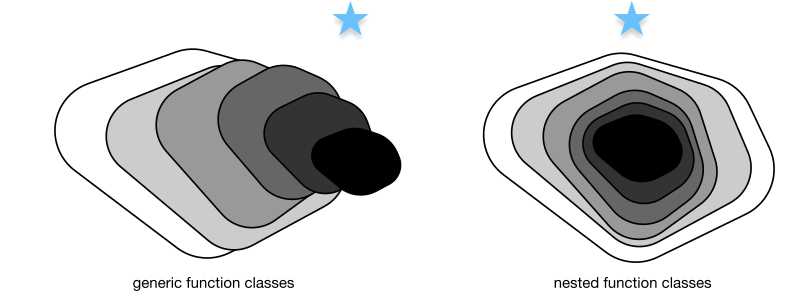

In [ ]:
Image("functionclasses.png",width=420)

- As more layers are added, training becomes more difficult due to
  the vanishing gradient problem
- Also, adding a layer to an existing network changes the structure of
  the network
  - The network is forced to use the new layer, altering the
    structure
- The "function class" gains complexity, doesn't overlap with the
  shallower network
- [Zhang et al](https://arxiv.org/abs/1512.03385) ask: what if we structure the network so we can nest
  function classes
  - Add layers in such a way that the network is free to ignore the
    new layers, can use the structures of the shallower network

https://d2l.ai/chapter_convolutional-modern/resnet.html

# Residual Blocks <a id="resblock" />

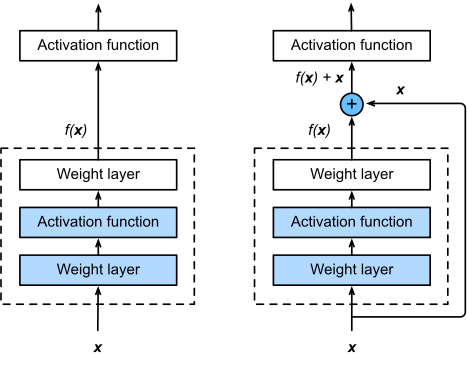

In [ ]:
Image("residual-block.png",width=380)


- The solution is to add new layers with a "skip" connection, an
  identity mapping around the new layers
- The new layers then get summed into the shallow network

- The network can skip over the "residual" part of the network
  initially in training, and act effectively as a shallow network,
  later in training set the residual as a kind of fine-tuning
  - "Residual", because $f(x)$ acts to induce a deviation from the
    shallow network topology

# Residual Block with Convolution

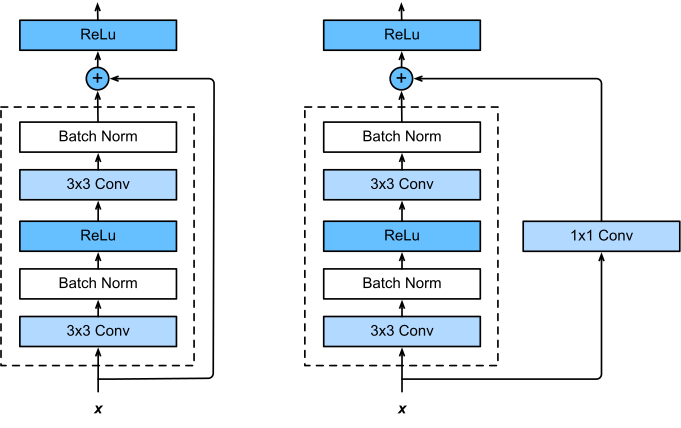

In [ ]:
Image("resnet-block.png",width=400)

- If we want to change the number of filters, then we can't add the
  residual component and the identity
- We need to resize the incoming layer, we can do this with a 1x1
  convolution:
  - This takes the filter vector at each pixel individually, and
    matrix multiplies to a different output size
  - Now we have the right number of filters
- If we also want to change the image size, we can add a stride to the
  1x1 convolution

# Global Average Pooling <a id="gap" />

- The final ingredient to ease the training is to change the `view` and
  fully-connected component at the end of the network
- Instead of changing the last convolution to a straight vector and
  connecting, we average over the values of each filter
  - This is *global average pooling*, we pool across the entire image
  - (sidenote: we can also use this to develop networks that don't
    need fixed input sizes)
- This reduces each filter to a single number, with no trainable parameters
- We can then fully-connect the global average pooled layer to the outputs
- Some advantages of a GAP layer:
  - We can have large final layer images
    but still be insensitive to the exact position of feature
  - We can have large image layers at the final convolution reduced down
    to manageable features without an explosion of trainable parameters
- This leads to networks with fewer parameters, more trainable, but
  still with large capacity

# The Residual Network (ResNet) <a id="resnet" />

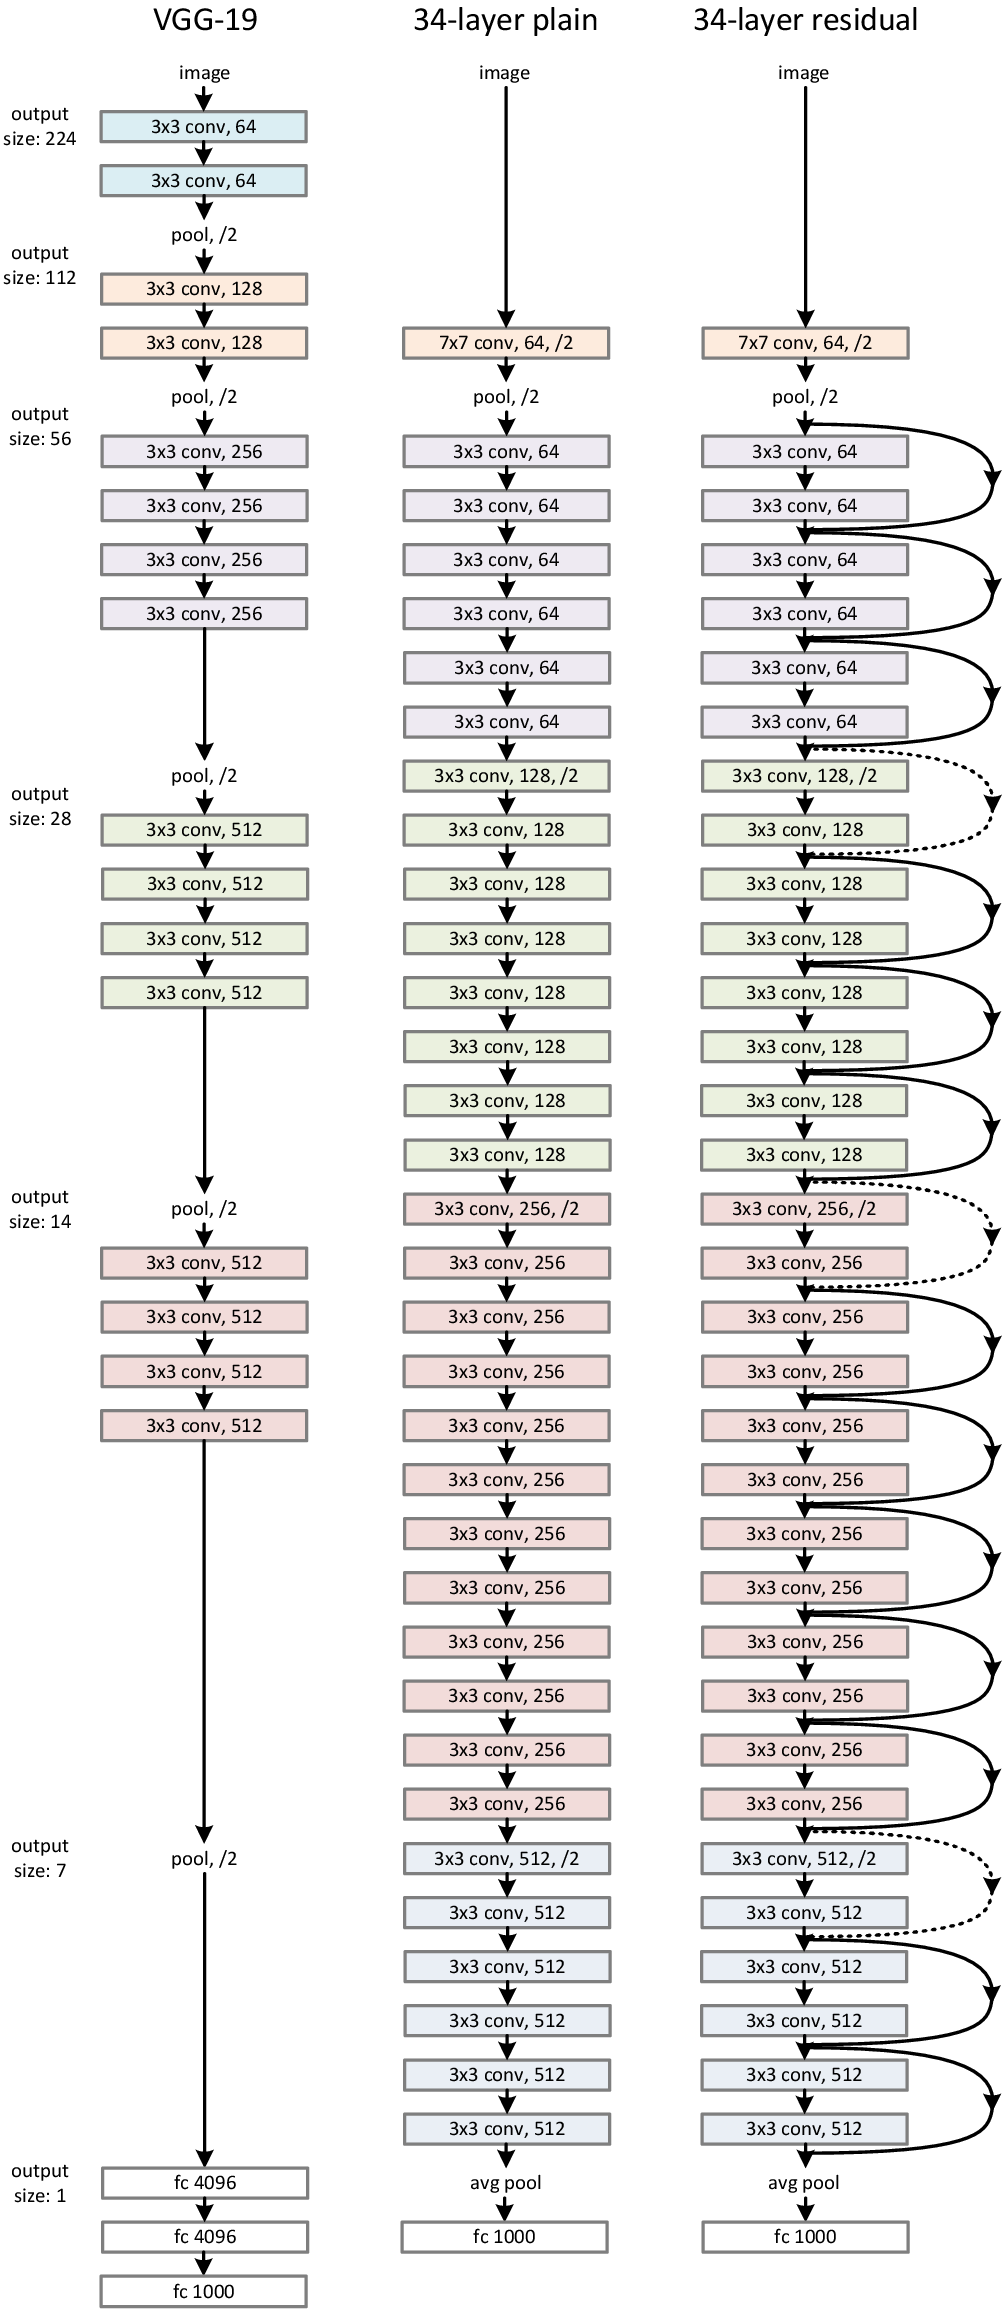

In [ ]:
Image("arch.png", width=200)

- If we put these ideas together, we end up with ResNet
  - Winner of the 2015 ILSVRC
- Dotted lines increase the dimension (more filters per layer, but
  with a pooling to reduce image size, 1x1 convolutions are applied to
  the skip connection to increase the size)
- This allowed very deep networks to be built, while still being
  trainable without needing to resort to special techniques and
  multiple attempts

# Residual Blocks in Pytorch

- Because pytorch tensors can be stored and manipulated as normal
  python objects, its straightforward to create a residual block
  - This could be separate as shown, or simply a part of the full network
- We just need to save the input, store the residual calculation in a
  separate object, then sum them at the end
- Once we've written this block, we can use it in our full networks, the same as we use e.g. `Conv2d`
  - You can try to add parameters to the `__init__` function to make it more general for instance

In [ ]:
class ResBlock(torch.nn.Module):
  def __init__(self):
    super(ResBlock, self).__init__()
    self.c1 = torch.nn.Conv2d(3,3,3,padding=1) # 3x3 filter, 3 channels -> 3 channels
    self.c2 = torch.nn.Conv2d(3,3,3,padding=1) # 3x3 filter, 3 channels -> 3 channels
  def forward(self, x):
    fx = self.c1(x)
    fx = torch.relu(fx) # we could also add a batchnorm layer, etc.
    fx = self.c2(fx)
    x = x + fx
    return torch.relu(x)

In [ ]:
r = ResBlock()
x = torch.randn((1,3,4,4))
print(x.shape,r(x).shape)

torch.Size([1, 3, 4, 4]) torch.Size([1, 3, 4, 4])


* Residual Blocks with Convolution

- Its also easy to change the number of filters by adding a
  convolution to the identity (non-residual) tensor

In [ ]:
class ResBlock(torch.nn.Module):
  def __init__(self):
    super(ResBlock, self).__init__()
    self.c1 = torch.nn.Conv2d(3,6,3,padding=1) # 3x3 filter, 3 channels -> 6 channels
    self.c2 = torch.nn.Conv2d(6,6,3,padding=1) # 3x3 filter, 6 channels -> 6 channels
    self.cc = torch.nn.Conv2d(3,6,1) # 1x1 filter 3 channels -> 6 channels
  def forward(self, x):
    fx = self.c1(x)
    fx = torch.relu(fx) # we could also add a batchnorm layer, etc.
    fx = self.c2(fx)
    x = self.cc(x) # convolve to more channels
    x = x + fx     # so we can add together
    return torch.relu(x)

In [ ]:
r = ResBlock()
x = torch.randn((1,3,4,4))
print(x.shape,r(x).shape)

torch.Size([1, 3, 4, 4]) torch.Size([1, 6, 4, 4])


# Residual Blocks with Convolution and Pooling

- The full ResNet block had also pooling, we can add padding to the
  convolution block to compensate the non-residual part

In [ ]:
class ResBlock(torch.nn.Module):
  def __init__(self):
    super(ResBlock, self).__init__()
    self.c1 = torch.nn.Conv2d(3,3,3,padding=1) # 3x3 filter, 3 channels -> 3 channels
    self.c2 = torch.nn.Conv2d(3,6,3,padding=1) # 3x3 filter, 3 channels -> 6 channels
    self.cc = torch.nn.Conv2d(3,6,1,stride=2) # 1x1 filter 3 channels -> 6 channels, padding to match pooling
    self.pool = torch.nn.MaxPool2d(2)
  def forward(self, x):
    fx = self.c1(x)
    fx = self.pool(torch.relu(fx))
    fx = self.c2(fx)
    x = self.cc(x) # includes the padding->shrinks the image
    x = x + fx
    return torch.relu(x)

In [ ]:
r = ResBlock()
x = torch.randn((1,3,4,4))
print(x.shape,r(x).shape)

torch.Size([1, 3, 4, 4]) torch.Size([1, 6, 2, 2])


# Global Average Pooling in Pytorch

- Pytorch doesn't have a "global average pooling" layer, instead it
  has a slightly more general "adaptive average pooling" layer
- `torch.nn.AdaptiveAvgPool2d(output_size)` will take in any size
  image of several filters, and output an `output_size` (either (h,w)
  or h for (h,h)) image where each filter gets averaged down to the size
  - For input size (i,c,ih,iw), the output size is (i,c,h,w)
- Instead of fixing the kernel size and stride to average over, the kernel
  size and stride is adapted to give the correct output size for the input
- So, a global average pooling is easily done with:
  `torch.nn.AdaptiveAvgPool2d(1)` (output size (i,c,1,1))

In [ ]:
gap = torch.nn.AdaptiveAvgPool2d(1)
print(gap(torch.tensor([ [ [[1.,1.],[1.,1.]] ] ])))
print(gap(torch.tensor([ [ [[2.,1.],[1.,2.],[1.,2.]] ] ])))
print(gap(torch.tensor([ [ [[2.,2.,3],[2.,2.,3.]] ] ])))

tensor([[[[1.]]]])
tensor([[[[1.5000]]]])
tensor([[[[2.3333]]]])



- The ResNet paper showed that they could successfully train a network
  *over 1000 layers deep*, with the only issue being that the network
  was prone to overtrainning because of too many parameters
- Other advanced networks to look at include:
  - GoogLeNet: contains an "inception" module, like our residual
    block, but with multiple paths with different sized filters
    (1x1,3x3,5x5,7x7) along each path
    - They wanted the network to look at features of various size at the same time
  - DenseNet: extends the idea of the skip connection, but
    concatenates the layers instead of summing and uses multiple skip connections

# Exercises <a id="exercises" />

- We will try the galaxy zoo, this time with a Resnet

0. Create a network with the following structure, which has two
   residual connections (one with, and one without a
   convolution). Note: input is at the bottom and the network goes
   up. The residual block can be a separate `torch.nn.Module` or it
   can simply be part of the network.

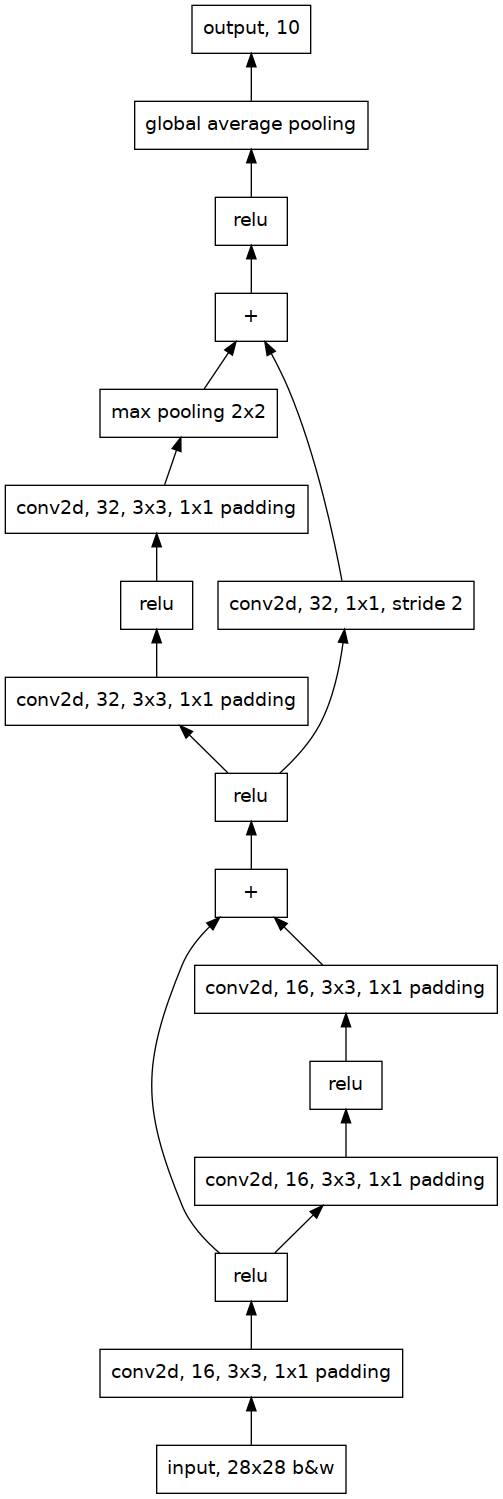

In [ ]:
Image("small-resnet.png", width=180)

In [ ]:
class ResNet1(th.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c1 = th.nn.Conv2d(1,16,3,padding=1)
        self.c2 = th.nn.Conv2d(16,16,3,padding=1)
        self.c3 = th.nn.Conv2d(16,32,3,padding=1)
        self.c4 = th.nn.Conv2d(32,32,3,padding=1)
        self.cc = th.nn.Conv2d(16,32,1,stride=2)

        self.mpool = th.nn.MaxPool2d(2)
        self.gap = th.nn.AdaptiveAvgPool2d(1)

        self.fc = th.nn.Linear(32,10)

    def forward(self, x): # (-1, 1, 28, 28)
        fx1 = self.c1(x)
        fx1 = th.relu(fx1)
        fx2 = self.c2(fx1)
        fx2 = th.relu(fx2)
        fx2 = self.c2(fx2)
        
        x = fx1 + fx2
        x = th.relu(x)

        fx3 = self.c3(x)
        fx3 = th.relu(fx3)
        fx3 = self.c4(fx3)
        fx3 = self.mpool(fx3) # (-1, 32, 14, 14)
                
        fx4 = th.relu(x)
        fx4 = self.cc(fx4)

        x = fx3 + fx4
        x = th.relu(x)
        
        x = self.gap(x) # (-1, 32, 1, 1)
        x = self.fc(x.view(-1, 32))
        return x

1. The previous network has a 28x28 input and 10 outputs, so it can
   fit, for example, FashionMNIST. Train the network on the FashionMNIST, how
   does its performance compare to your previous FashionMNIST
   networks.

In [1]:
import torch as th
import torchvision as tv
from collections import defaultdict
import matplotlib.pyplot as plt

train1 = tv.datasets.FashionMNIST('/data/MNIST', download=True, train=True, transform=tv.transforms.ToTensor())
train = th.utils.data.DataLoader(train1, batch_size=512)
test1 = tv.datasets.FashionMNIST('/data/MNIST', download=True, train=False, transform=tv.transforms.ToTensor())
test = th.utils.data.DataLoader(test1, batch_size=512)

# x, y = next(iter(train))
# print(x.shape)


Extracting /data/MNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/FashionMNIST/raw




Extracting /data/MNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/FashionMNIST/raw




Extracting /data/MNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/FashionMNIST/raw




Extracting /data/MNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
device = 'cuda'

net = ResNet1().to(device)
opt = th.optim.Adam(net.parameters())
l = th.nn.CrossEntropyLoss()
per_epoch = defaultdict(lambda:[])
last_save = 0
e = 0

while last_save < 2:
    per_batch = defaultdict(lambda:[])
    i = 0
    for images, labels in train :

        opt.zero_grad()
        outputs = net(images.to(device))
        loss = l(outputs, labels.to(device))
        loss.backward()
        opt.step()
        per_batch["loss"].append(loss.item()*images.size(0))
        per_batch["corr"].append(sum(th.max(outputs,1)[1].cpu()==labels))
        per_batch["n"].append(images.size(0))
    per_epoch["loss"].append(sum(per_batch["loss"])/sum(per_batch["n"]))
    per_epoch["acc"].append(sum(per_batch["corr"])/sum(per_batch["n"]))
    for images, labels in test :
        outputs = net(images.to(device))
        loss = l(outputs, labels.to(device))
        per_batch["tloss"].append(loss.item()*images.size(0))
        per_batch["tcorr"].append(sum(th.max(outputs,1)[1].cpu()==labels))
        per_batch["tn"].append(images.size(0))
    per_epoch["tloss"].append(sum(per_batch["tloss"])/sum(per_batch["tn"]))
    per_epoch["tacc"].append(sum(per_batch["tcorr"])/sum(per_batch["tn"]))
    print(f'epoch {e:03d} : train loss {per_epoch["loss"][-1]:.3f} acc {per_epoch["acc"][-1]:.3f} test loss {per_epoch["tloss"][-1]:.3f} acc {per_epoch["tacc"][-1]:.3f}')
    # early stopping: if we are at the best epoch (= epoch with lowest loss), save the weights
    last_save += 1; e += 1
    if per_epoch["tloss"][-1] == min(per_epoch["tloss"]):
        print("  saving network")
        th.save(net.state_dict(), 'fnet_weights.pt')
        last_save = 0
print("done training.")


epoch 000 : train loss 1.811 acc 0.310 test loss 1.414 acc 0.460
  saving network
epoch 001 : train loss 1.220 acc 0.541 test loss 1.087 acc 0.634
  saving network
epoch 002 : train loss 0.991 acc 0.641 test loss 0.955 acc 0.664
  saving network
epoch 003 : train loss 0.898 acc 0.677 test loss 0.866 acc 0.708
  saving network
epoch 004 : train loss 0.829 acc 0.704 test loss 0.812 acc 0.724
  saving network
epoch 005 : train loss 0.780 acc 0.724 test loss 0.762 acc 0.742
  saving network
epoch 006 : train loss 0.743 acc 0.738 test loss 0.734 acc 0.748
  saving network
epoch 007 : train loss 0.711 acc 0.748 test loss 0.724 acc 0.753
  saving network
epoch 008 : train loss 0.684 acc 0.757 test loss 0.723 acc 0.759
  saving network
epoch 009 : train loss 0.660 acc 0.765 test loss 0.702 acc 0.768
  saving network
epoch 010 : train loss 0.640 acc 0.772 test loss 0.680 acc 0.773
  saving network
epoch 011 : train loss 0.624 acc 0.778 test loss 0.663 acc 0.777
  saving network
epoch 012 : trai

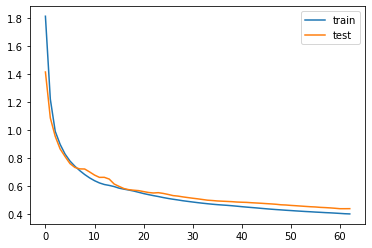

In [ ]:

# # reload the best weights
# net.load_state_dict(th.load('fnet_weights.pt'))
# Make plots of the training/testing losses
plt.plot(per_epoch["loss"], label="train")
plt.plot(per_epoch["tloss"], label="test")
plt.legend(loc="upper right")

2. Now we will train a ResNet on a new dataset: the galaxy zoo. https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/overview

- The galaxy zoo is a citizen science project: webusers are given
  galaxy images from the sloan digital sky survey and asked to answer
  a survey about the galaxy (multiple paths)
- The full challenge requires the classifier to predict the responses
  to the full questionaire, what fraction of the respondents answer
  yes to each (paths not gone done are assigned no)
  - So, it seems like a classification task, but really its a
    multi-output regression problem

- We will take a pretrained model and rerun it to solve a simplified version of the galaxy zoo:
  - Instead of predicting the output of all questions, we will try to
    predict the output of just one of the questions: does the galaxy
    have spiral arms? i.e. the classifier should answer the question:
    is our image an image of a spiral galaxy?
  - (Or rather, what fraction of webusers would say that this image is
    an image of a spiral galaxy)


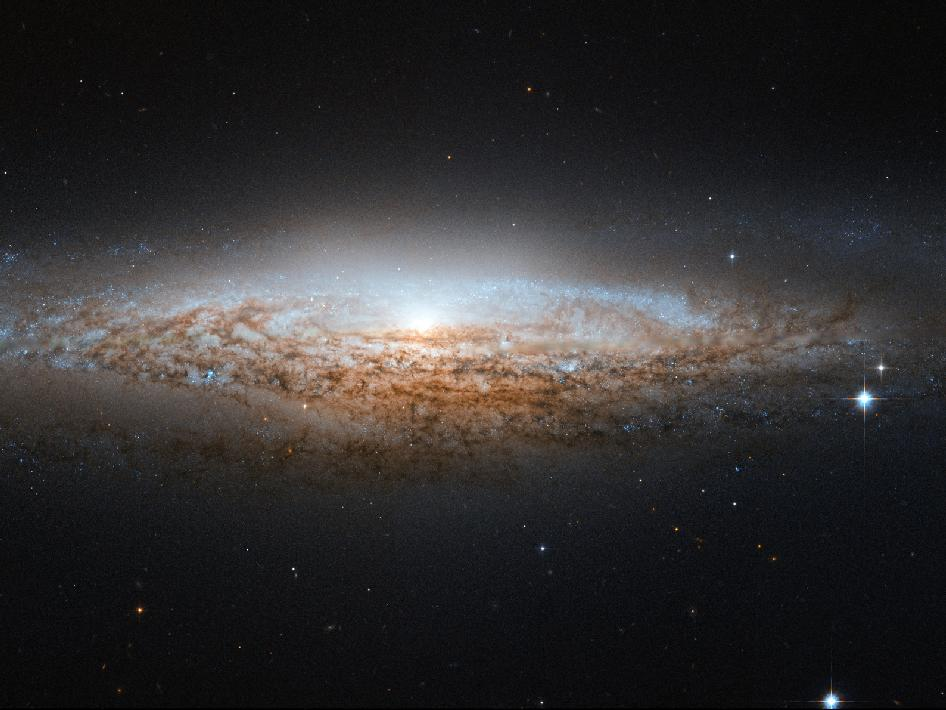

In [ ]:
Image("galaxy_image.jpg", width=160)

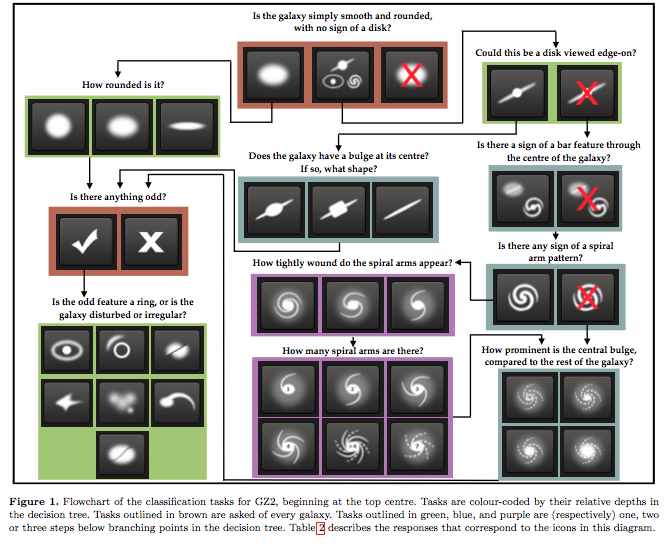

In [ ]:
Image("decision_tree.png", width=480)

Here are some dataloaders you can use. It splits the dataset into 90%
training and 10% testing. The transforms are set up to resize the
images to 224x224 which was a standard input size for many previous image classification competitions.

Run one of the below. Note that on colab you should download the data, on gate you should use the existing dataset. Choose the right one, run just one!

*If you are on colab run this cell to download the galaxy zoo dataset and unzip to the current directory*

In [2]:
# someone has helpfully put the galaxy zoo on google drive so this should be quick

!gdown https://drive.google.com/uc?id=1kXTFPIOp6ctIn4RJ8RoxMhklulpC6SV9
!gdown https://drive.google.com/uc?id=1cBCgj-9bnsW91X4vEiuNm8Ms4XJ3MfYo

!unzip training_solutions_rev1.zip
!unzip images_training_rev1.zip
!ls -l
datadir='./'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: images_training_rev1/926462.jpg  
  inflating: images_training_rev1/926478.jpg  
  inflating: images_training_rev1/926480.jpg  
  inflating: images_training_rev1/926484.jpg  
  inflating: images_training_rev1/926488.jpg  
  inflating: images_training_rev1/926509.jpg  
  inflating: images_training_rev1/926522.jpg  
  inflating: images_training_rev1/926544.jpg  
  inflating: images_training_rev1/926547.jpg  
  inflating: images_training_rev1/926548.jpg  
  inflating: images_training_rev1/926551.jpg  
  inflating: images_training_rev1/926602.jpg  
  inflating: images_training_rev1/926630.jpg  
  inflating: images_training_rev1/926649.jpg  
  inflating: images_training_rev1/926655.jpg  
  inflating: images_training_rev1/926657.jpg  
  inflating: images_training_rev1/926675.jpg  
  inflating: images_training_rev1/926676.jpg  
  inflating: images_training_rev1/926696.jpg  
  inflating: images_training_rev1/926725.jpg  
  inflating: images_trai

*If you are on gate, use this directory for the dataset*

In [ ]:
datadir='/store/user/iawatson/galaxy-zoo'

*If you are me running on my local workstation*

In [ ]:
datadir='/data/kaggle/galaxy'

In [50]:
import torchvision as tv
import torch as tha
import pandas as pd
import PIL
class ZooTrain(object):
  def __init__(self, transforms=tv.transforms.Compose([tv.transforms.ToTensor()])):
    self.csv = pd.read_csv(f'{datadir}/training_solutions_rev1.csv')
    self.id = self.csv["GalaxyID"].values[:int(9*len(self.csv)/10)]
    self.spiral = self.csv["Class4.1"].values[:int(9*len(self.csv)/10)]
    self.transforms = transforms
  def __getitem__(self, idx):
    return (self.transforms(PIL.Image.open(f"{datadir}/images_training_rev1/{self.id[idx]}.jpg")), 
            th.tensor(self.spiral[idx]).float().unsqueeze(-1))
  def __len__(self):
    return len(self.spiral)

class ZooTest(object):
  def __init__(self, transforms=tv.transforms.Compose([tv.transforms.ToTensor()])):
    self.csv = pd.read_csv(f'{datadir}/training_solutions_rev1.csv')
    self.id = self.csv["GalaxyID"].values[int(9*len(self.csv)/10):]
    self.spiral = self.csv["Class4.1"].values[int(9*len(self.csv)/10):]
    self.transforms = transforms
  def __getitem__(self, idx):
    return (self.transforms(PIL.Image.open(f"{datadir}/images_training_rev1/{self.id[idx]}.jpg")), 
            th.tensor(self.spiral[idx]).float().unsqueeze(-1))
  def __len__(self):
    return len(self.spiral)

tr = tv.transforms.Compose([
  tv.transforms.Resize(224),
  tv.transforms.ToTensor(),
])
zoo_train_ = ZooTrain(tr)

tr = tv.transforms.Compose([
  tv.transforms.Resize(224),
  tv.transforms.ToTensor(),
])
zoo_test_ = ZooTest(tr)

zoo_train = th.utils.data.DataLoader(zoo_train_, batch_size=32)
zoo_test = th.utils.data.DataLoader(zoo_test_, batch_size=32)

If there's any issues with loading the data, let me know ASAP! Note that the batch size is fairly high if you have a small GPU, on colab, you may need to reduce the batch size (it should be no problem for the V100s on gate though)

Use matplotlib to show the first few galaxies in the dataset.

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


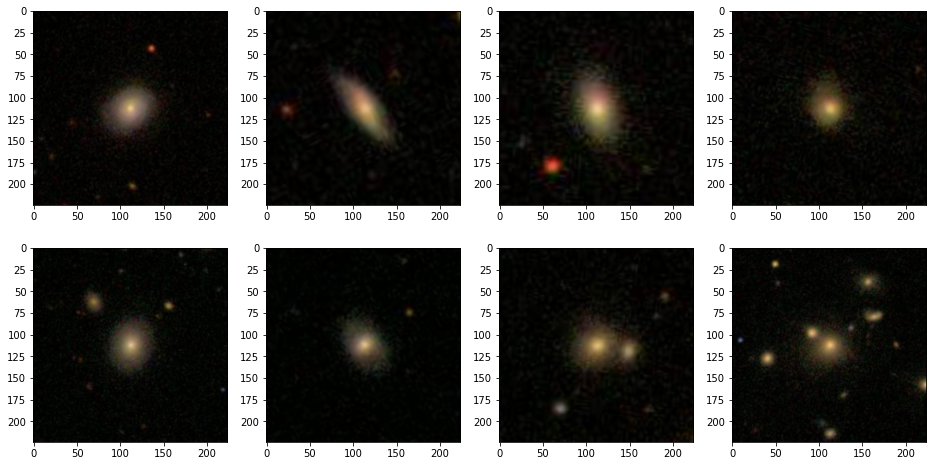

In [33]:
import matplotlib.pyplot as plt

x,y = next(iter(zoo_train)) #DataLoader를 사용하여 만든 trainloader를 iter안에 넣어 image와 label을 차례대로 호ㅏㄱㅣ
# print(x.shape, y.shape, len(zoo_train), len(zoo_test))

plt.figure(figsize=(16,8))

for i in range(8):
    # print(f'(image num {i}) label :{y[i].item()}')
    plt.subplot(2,4,i+1)
    print(x[i].size())
    plt.imshow(x[i].permute(1,2,0))

Now create a ResNet style network (a couple of resnet blocks, a pooling layer, a couple of resnet blocks, pooling ... then a final Global Avg. Pooling layer into the binary output) for the galaxy zoo dataset.

In [60]:
class ResNet2(th.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c1 = th.nn.Conv2d(3,16,3,padding=1)
        self.c2 = th.nn.Conv2d(16,16,3,padding=1)
        self.c3 = th.nn.Conv2d(16,32,3,padding=1)
        self.c4 = th.nn.Conv2d(32,32,3,padding=1)
        self.c5 = th.nn.Conv2d(32,64,5,padding=2)
        self.c6 = th.nn.Conv2d(64,64,5,padding=2)
        self.c7 = th.nn.Conv2d(64,128,5,padding=2)
        self.c8 = th.nn.Conv2d(128,128,5,padding=2)

        self.cc1 = th.nn.Conv2d(16,32,1,stride=2)
        self.cc2 = th.nn.Conv2d(64,128,1,stride=2)

        self.mpool = th.nn.MaxPool2d(2)
        self.gap = th.nn.AdaptiveAvgPool2d(1)

        self.fc = th.nn.Linear(128,1)

    def forward(self, x):
        fx1 = self.c1(x)
        fx1 = th.relu(fx1)
        fx2 = self.c2(fx1)
        fx2 = th.relu(fx2)
        fx2 = self.c2(fx2)
        
        x = fx1 + fx2
        x = th.relu(x)

        fx3 = self.c3(x)
        fx3 = th.relu(fx3)
        fx3 = self.c4(fx3)
        fx3 = self.mpool(fx3) 
                
        fx4 = th.relu(x)
        fx4 = self.cc1(fx4)

        x = fx3 + fx4
        x = th.relu(x)

        fx5 = self.c5(x) # (-1, 64, 56, 56)
        fx5 = th.relu(fx5)
        fx6 = self.c6(fx5)
        fx6 = th.relu(fx6)
        fx6 = self.c6(fx6)
       
        x = fx5 + fx6
        x = th.relu(x)

        fx8 = self.cc2(x) 
        fx7 = self.c7(x)
        fx7 = th.relu(fx7)
        fx7 = self.c8(fx7)
        fx7 = self.mpool(fx7)

        x = fx7 + fx8
        x = th.relu(x)
        x = self.gap(x)
        x = self.fc(x.view(-1, 128))
        x = th.sigmoid(x)
        return x

Train your ResNet on the galaxy zoo training dataset. It might require some hyperparameter optimization and use of the regularization techniques from last week to get a good model. 

Remember, it seems like a classification problem (find the spiral galaxies), but really its regression (what fraction of users would say its a spiral galaxy), so you might want to use `MSELoss` or similar for the the loss function. Be sure to monitor the training and test losses.

In [61]:



device = 'cuda'

net = ResNet2().to(device)
opt = th.optim.Adam(net.parameters())
l = th.nn.MSELoss() #이미지를 할때는 Loss function을 MESLOSS로
per_epoch = defaultdict(lambda:[])
last_save = 0
e = 8


for i in range(e):
# while last_save < 2:
    per_batch = defaultdict(lambda:[])
    for images, labels in zoo_train :

        opt.zero_grad()
        outputs = net(images.to(device))
        loss = l(outputs, labels.to(device))
        loss.backward()
        opt.step()
        per_batch["loss"].append(loss.item()*images.size(0))
        per_batch["n"].append(images.size(0))
    per_epoch["loss"].append(sum(per_batch["loss"])/sum(per_batch["n"]))
    per_batch = defaultdict(lambda:[])

    for images, labels in zoo_test :
        outputs = net(images.to(device))
        loss = l(outputs, labels.to(device))
        per_batch["tloss"].append(loss.item()*images.size(0))
        per_batch["tcorr"].append(sum(th.max(outputs,1)[1].cpu()==labels))
        per_batch["tn"].append(images.size(0))
    per_epoch["tloss"].append(sum(per_batch["tloss"])/sum(per_batch["tn"]))
   
    print(f'epoch {i:03d} : train loss {per_epoch["loss"][-1]:.3f} test loss {per_epoch["tloss"][-1]:.3f}')
    # early stopping: if we are at the best epoch (= epoch with lowest loss), save the weights
    # last_save += 1; e += 1
    # if per_epoch["tloss"][-1] == min(per_epoch["tloss"]):
    #     print("  saving network")
    #     th.save(net.state_dict(), 'fnet_weights.pt')
    #     last_save = 0
print("done training.")


epoch 000 : train loss 0.068 test loss 0.066
epoch 001 : train loss 0.061 test loss 0.060
epoch 002 : train loss 0.050 test loss 0.042
epoch 003 : train loss 0.039 test loss 0.037
epoch 004 : train loss 0.035 test loss 0.036
epoch 005 : train loss 0.033 test loss 0.032
epoch 006 : train loss 0.031 test loss 0.032
epoch 007 : train loss 0.030 test loss 0.031
done training.


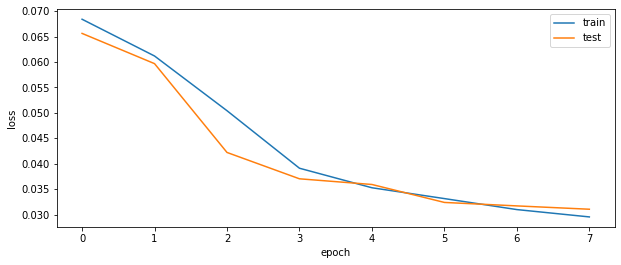

In [62]:
import matplotlib.pyplot as plt

# plot
plt.figure(figsize=(10,4))
plt.plot(per_epoch["loss"], label='train')
plt.plot(per_epoch["tloss"], label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

3. From the testing dataset, find the top 5 most spiral-arm-like
   galaxies, as classified by your network.  That is, run your network
   over the test set and keep track of the top 5 images as ranked by
   your (trained) network output. Draw them, do they look like spiral
   galaxies to you?